# Text Classification

In this problem, you will be analyzing the Twitter data we extracted using [this](https://dev.twitter.com/overview/api) api. This time, we extracted the tweets posted by the following six Twitter accounts: `realDonaldTrump, mike_pence, GOP, HillaryClinton, timkaine, TheDemocrats`.

For every tweet, we collected two pieces of information:
- `screen_name`: the Twitter handle of the user tweeting and
- `text`: the content of the tweet.

We divided the tweets into two parts - the train and test sets.  The training set contains both the `screen_name` and `text` of each tweet; the test set only contains the `text`.

The overarching goal of the problem is to infer the political inclination (whether **R**epublican or **D**emocratic) of the author from the tweet text. The ground truth (i.e., true class labels) are determined from the `screen_name` of the tweet as follows:
- **R**: `realDonaldTrump, mike_pence, GOP`
- **D**: `HillaryClinton, timkaine, TheDemocrats`

We can treat this as a binary classification problem. We'll follow this common structure to tackling this problem:

1. **preprocessing**: clean up the raw tweet text using the various functions offered by [the Natural Language Toolkit (`nltk`)](http://www.nltk.org/genindex.html).
2. **features**: construct bag-of-words feature vectors.
3. **classification**: learn a binary classification model using [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html). 

Note that `nltk` supports optional corpora, toy grammars, trained models, etc. For this assignment, you have to manually install the stopwords list and `WordNetLemmatizer`. We'll begin by installing them:

In [1]:
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import re
import matplotlib.pyplot as plt

from testing.testing import test

def nltk_download_test(nltk_download):
    nltk_download()
    try:
        lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
        test.true(lemmatizer is not None)
        stopwords=nltk.corpus.stopwords.words('english')
        test.true(stopwords is not None)
    except LookupError:
        test.true(False)
        
@test
def nltk_download():
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

### TESTING nltk_download: PASSED 2/2
###



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mujumdar's\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mujumdar's\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mujumdar's\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Text Processing

You first task to fill in the following function which processes and tokenizes raw text. The tokens must:

1. be in lower case.
2. appear in the same order as in the raw text.
3. be in their lemmatized form, if one exists. If a word cannot be lemmatized, do not include it in the output.
4. **not** contain any characters other than numbers and digits; you should:
   1. remove trailing `'s`: `Children's` becomes `children`
   2. omit other apostrophes: `don't` becomes `dont`
   3. break tokens at other punctuation and/or unicode characters: `word-of-mouth` becomes `word`, `of`, `mouth` 
5. if the lemmatized form is a stopword, it should not appear in the output
6. not include the parts of any t.co urls. Many tweets contain URLs from the domain `t.co`; you should strip all such URLs.

If you figure out the right order to perform these operations, solving this problem is much easier.

**Stopwords** are words that appear very often in text, usually playing a grammatical role ("and", "a", etc.). When comparing text similarity, these are not very useful; so we eliminate them at this stage. (NLTK provides us with a list of stopwords for English, which we will use later.)

Hints:

 - `string.punctuation` is a string of all the punctuation symbols
 - you should use `nltk.word_tokenize()` in your solution
 - you should break tokens at all characters that are not in `string.ascii_letters` or `string.digits`
 - test your URL stripping! It's very easy to make a mistake with it.

In [14]:
def preprocess_test(preprocess):
    test.equal(preprocess("I'm doing well! How about you?"), ['im', 'doing', 'well', 'how', 'about', 'you'])
    test.equal(preprocess("Education is the ability to listen to almost anything without losing your temper or your self-confidence."),    ['education', 'is', 'the', 'ability', 'to', 'listen', 'to', 'almost', 'anything', 'without', 'losing', 'your', 'temper', 'or', 'your', 'self', 'confidence'])

    #Punctuation and space handling
    test.equal(preprocess(" a..a. .a . a."), ['a', 'a', 'a', 'a'])
    test.equal(preprocess("word-of-mouth self-esteem"), ['word', 'of', 'mouth', 'self', 'esteem'])

    # Apostrophe handling
    test.equal(preprocess("you've"), ['youve'])
    test.equal(preprocess("She's"), ['she'])
    test.equal(preprocess("Cea'sar"), ['ceaar']) # You can assume that there are no mid-word "'s" substrings.

    # Lemmatizer
    test.equal(preprocess("walks"), ['walk'])
    
    # Stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    test.equal(preprocess("I'm doing well! How about you?", stopwords), ['im', 'well'])
    test.equal(preprocess("Education is the ability to listen to almost anything without losing your temper or your self-confidence.", stopwords), ['education', 'ability', 'listen', 'almost', 'anything', 'without', 'losing', 'temper', 'self', 'confidence'])

    # Unicode handling
    test.equal(preprocess("doot👏doot"), ["doot", "doot"])

    #URL handling
    test.equal(preprocess("http://t.co/WJs5bmRthU,http://t.co/WJs5bmRthU,"), [])
    test.equal(preprocess("boohttp://t.co/WJs5bmRthUhello"), ["boo", "hello"])

@test
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    
    args:
        text: str -- raw text
        stopwords : Set[str] -- lemmatized tokens to exclude from the output
        lemmatizer : Lemmatizer -- an instance of a class implementing the lemmatize() method

    Outputs:
        list(str): tokenized text
    """

    text =re.sub('(http|https)://t.co/[0-9a-zA-Z]{10}', ' ', text, flags=re.MULTILINE)
    text=text.lower()
    
    def replace_emoji(text):
        return ''.join([i if ord(i) < 128 else ' ' for i in text])
    text = replace_emoji(text)
    
    text=text.replace("'s","")
    text=text.replace("'","")
    l=len(string.punctuation)
    tr=str.maketrans(string.punctuation," "*l)
    text=text.translate(tr)
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [token for token in tokens if token not in stopwords]
    #tokens = [token for token in tokens if token in string.ascii_letters or string.digits]
    
    return tokens
    pass

### TESTING preprocess: PASSED 13/13
###



We give you some code that uses `preprocess` to prepare the data. This should take no more than 6s to run; if it takes longer than that, you need to make your preprocessing function run quicker.

In [15]:
# %%timeit
## Uncomment the previous line to time your code. Remember to comment it out before uploading your solution.

def read_data_test(read_data):
    data_train, data_test = read_data()
    
    test.equal(len(data_train), 17298)
    test.equal(len(data_test), 1000)

def read_csv(stem, process=lambda x: x):
    with gzip.open(f"{stem}.csv.gz", "rt", newline='', encoding="UTF-8") as file:
        csvr = csv.reader(file)
        next(csvr)
        return list(map(process, csvr))

def is_republican(r):
    return r in ["realDonaldTrump", "mike_pence", "GOP"]

@test
def read_data(extra_stopwords=set()):
    """Reads the dataset from the csv.gz files
    
    return : Tuple[data_train, data_test]
        data_train : List[Tuple[is_republican, tokenized_tweet]]
            is_republican : bool -- True if tweet is from a republican
            tokenized_tweet : List[str] -- the tweet, tokenized by preprocess()
    """
    stopwords = set(nltk.corpus.stopwords.words('english')) | set(["http", "co", "rt", "amp"]) | extra_stopwords
    data_train = read_csv("tweets_train", process=lambda r: (is_republican(r[0]), preprocess(r[1], stopwords)))
    data_test = read_csv("tweets_test", process=lambda r: preprocess(r[0], stopwords))
    
    return (data_train, data_test)

### TESTING read_data: PASSED 2/2
###



## 2. Feature Construction

The next step is to derive feature vectors from the tokenized tweets. In this section, you will be constructing a bag-of-words [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) feature vector.

The number of possible words is prohibitively large, and not all words are useful for our task. We will begin by filtering the vectors using a common heuristic:

We calculate a frequency distribution of words in the corpus, and remove words at the head (most frequent) and tail (least frequent) of the distribution. Most frequently used words (often called stopwords) provide very little information about the similarity of two pieces of text; we have already removed these. Words with extremely low frequency tend to be typos.

We will now implement a function which counts the number of times that each token is used in the training corpus. You should return a [`collections.Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) object with the number of times that each word appears in the dataset.

(This should take no more than 20s to run, including reading the files.)

### TESTING get_distribution: PASSED 8/8
###



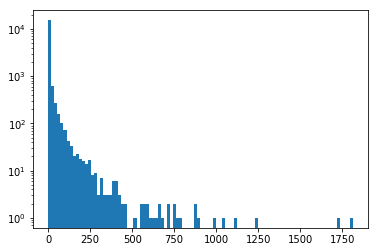

In [16]:
def get_distribution_test(get_distribution):
    data_train, data_test = read_data()
    dist = get_distribution(data_train)
    test.true(isinstance(dist, collections.Counter))
    if dist is None:
        return

    test.equal(dist['trump'], 1812)
    test.equal(dist['clinton'], 1107)
    test.equal(dist['president'], 788)
    test.equal(dist['american'], 745)
    test.equal(dist['job'], 676)
    test.equal(dist['obama'], 438)
    test.equal(dist['hoosier'], 393)

    plt.hist(dist.values(), bins=100)
    plt.yscale('log')

@test
def get_distribution(data_train):
    """ Calculates the word count distribution, excluding stopwords.

    args: 
        data_train -- the training data

    return : collections.Counter -- the distribution of word counts
    """
    word_count=collections.Counter()
    for tag, data in data_train:
        for word in data:
            word_count[word]+=1
    
    return word_count
            
    pass

Notice the distribution looks exponential, even with a logarithmic y-axis; there are a lot words that appear only once. Lets figure out what these words are so we can eliminate them from the dataset.

In [17]:
def get_rare_words_test(get_rare_words):
    data_train, data_test = read_data()
    dist = get_distribution(data_train)
    new_stopwords = get_rare_words(dist)

    test.equal(len(new_stopwords), 8048)
    test.true("fugedaboudit" in new_stopwords)
    test.true("puppybowl" in new_stopwords)
    test.true("rusty" in new_stopwords)    

@test
def get_rare_words(dist):
    """use the word count information from the training data to find more stopwords

    args:
        dist: collections.Counter -- the output of get_distribution

    returns : Set[str] -- a set of all words that appear exactly once in the training data
    """
    
    rare_words=[i for i in dist if dist[i]==1]
    return set(rare_words)
    pass

### TESTING get_rare_words: PASSED 4/4
###



Here we provide a wrapper function to cache the preprocessed data. This helps it not take quite as long to re-run. If you change anything above this cell, re-run this cell to clear the cache.

In [18]:
global PREPROCESSED_DATA_CACHE
PREPROCESSED_DATA_CACHE = None

def get_data():
    global PREPROCESSED_DATA_CACHE
    if PREPROCESSED_DATA_CACHE is None:
        data_train, data_test = read_data()
        dist = get_distribution(data_train)
        new_stopwords = get_rare_words(dist)
        PREPROCESSED_DATA_CACHE = read_data(new_stopwords)

    return PREPROCESSED_DATA_CACHE

### Vectorizing

Now we have each tweet as a list of words, excluding words with high- and low-frequencies. We want to convert these into a sparse feature matrix, where each row corresponds to a tweet and each column to a possible word. We can use `scikit-learn`'s [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to do this quite easily.

There's a catch, though: `TfidfVectorizer` expects the input to be a string, and (by default) it perfoms its own analyzing. You have to override that behavior by passing in `do_nothing` to the constructor as an optional parameter.

Hints:

 - Read [the documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes) carefully, and then this [blog post](http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/) ([mirror](http://archive.is/pVdqE)). You need to pass in `do_nothing` in two locations.
 - You should use just the training data to `fit` or `fit_transform` the vectorizer.

In [25]:
# Helper function, do not change:
def do_nothing(x):
    return x

def create_features_test(create_features):
    train_features, train_labels, test_features = create_features(*get_data())

    test.equal(repr(train_features), """<17298x8714 sparse matrix of type '<class 'numpy.float64'>'
	with 161480 stored elements in Compressed Sparse Row format>""")

    test.equal(repr(test_features), """<1000x8714 sparse matrix of type '<class 'numpy.float64'>'
	with 9037 stored elements in Compressed Sparse Row format>""")

    test.equal(train_labels.dtype, bool)
    test.equal(len(train_labels), 17298)
    test.equal(sum(train_labels), 8646)

@test
def create_features(train_data, test_data):
    """creates the feature matrices and label vector for the training and test sets.

    args:
        train_data : List[Tuple[is_republican, tweet_words]]
            is_republican : bool -- True if Republican, False otherwise
            tweet_words : List[str] -- the processed tweet tokens
        test_data : List[List[str]] -- a list of processed tweets

    returns: Tuple[train_features, train_labels, test_features]
        train_features : scipy.sparse.csr.csr_matrix -- feature matrix for the training set
        train_labels : np.array[num_train] -- a numpy vector, where 1 stands for Republican and 0 stands for Democrat 
        test_features : scipy.sparse.csr.csr_matrix -- feature matrix for the test set
    """


    labels =[]
    data = []
    for tag, text in train_data:
        labels.append(tag)
        data.append(text)
    

    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='word',tokenizer=do_nothing,preprocessor=do_nothing,token_pattern=None)  
    X = tfidf.fit_transform(data)
    
    test = tfidf.transform(test_data)
    
    train_labels = np.array(labels)
    train_features = X
    test_features = test

    return (train_features, train_labels, test_features)

### TESTING create_features: PASSED 5/5
###



Observe that the created matrices are very sparse.

Now that we have the features, lets perform the classification:

## 3. Classification

We are ready to put it all together and train the classification model.

You will be will be using the Support Vector Machine [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). [Here](http://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html) is a quick introduction to SVMs.

At the heart of an SVM is the concept of a _kernel function_, which determines the distance between two data points. `sklearn.svm.SVC` natively supports four kernel functions: `linear`, `poly`, `rbf`, `sigmoid`. For this problem space, we will use the `linear` kernel.

In this section, we will:

1. build a classifier using the `linear` kernel,
2. train it using the training set,
3. evaluate the trained model on the training set, and then
4. use it to predict classification on our test set.

Let's begin by training a classifier. This should take no more than 20s to run. You should set the optional parameter `gamma` to `auto`, but leave the rest at their default values.

In [29]:
def learn_classifier_test(learn_classifier):
    train_features, train_labels, _ = create_features(*get_data())
    classifier = learn_classifier(train_features, train_labels)

    test.equal(repr(classifier).replace("\n", "").replace("  ", " ").replace("  ", " "), """SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)""")

@test
def learn_classifier(train_features, train_labels, kernel="linear"):
    """learns a classifier from the input features and labels using a specified kernel function

    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        kernel : str -- kernel function to be used with classifier, must be (linear|poly|rbf|sigmoid)

    return : sklearn.svm.classes.SVC -- classifier
    """
    
    svm=sklearn.svm.classes.SVC(kernel=kernel, gamma = "auto")
    svm.fit(train_features,train_labels)
    return svm

    assert kernel in ["linear", "poly", "rbf", "sigmoid"]

    pass # Implement this.

### TESTING learn_classifier: PASSED 1/1
###



Now that we know how to train a classifier, the next step is to measure its performance. This step is necessary to select the best model among a given set of models, or even tune hyperparameters for a given model.

We would ordinarily use a held-out validation set to evaluate the performance of the classifier. The use of a held-out set prevents overfitting to the data, and you will do this for another assignment. For this problem, though, we can use the training set.

To measure classification accuracy we will use the [$F_1$ score](https://en.wikipedia.org/wiki/F1_score). Implement this:

In [30]:
def f1_test(f1):
    test.equal(f1([1,1,1], [1,1,1]), 1.0)
    test.equal(f1([1,0,0], [1,0,0]), 1.0)
    test.equal(f1([1,1,0], [1,1,1]), 0.8)
    test.equal(f1([1,0,0], [1,1,0]), 2/3)
    test.equal(f1([0,0,1], [1,0,1]), 2/3)
    test.equal(f1([1,0,0], [1,1,1]), 0.5)

@test
def f1(pred, ground):
    """ evaluates a classifier based on a supplied validation data

    args:
        pred: numpy.ndarray(bool) -- predictions
        ground: numpy.ndarray(bool) -- known ground-truth values
    
    return : double -- the F1 score of the predictions
    """
    pred = np.array(pred, dtype=bool)
    ground = np.array(ground, dtype=bool)
    f1_score = sklearn.metrics.f1_score(ground, pred)
    
    return f1_score

    pass # Implement this

### TESTING f1: PASSED 6/6
###



Now we calculate the F1 score on the training set:

In [35]:
def evaluate_test(evaluate):
    train_features, train_labels, _ = create_features(*get_data())
    test.true(np.abs(evaluate(train_features, train_labels, 'linear') - 0.9538984242282234) < 1e-5)

@test
def evaluate(train_features, train_labels, kernel="linear"):
    """train the classifier and report the F1 score on the training set
    
    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        kernel : str -- kernel function to be used with classifier, must be (linear|poly|rbf|sigmoid)

    return : double -- the F1 score of the predictions on the training labels
    """
    classifier = learn_classifier(train_features, train_labels, kernel)
    pred=classifier.predict(train_features)
    f1_score = f1(train_labels, pred)
    return f1_score

### TESTING evaluate: PASSED 1/1
###



### Classifying Test Tweets

Home stretch! Now we can classify the test tweets! Use `learn_classifier` to make a trained classifier and predict the labels given the `test_features`.

In [38]:
def pp(entries):
    from IPython.display import HTML, display
    import tabulate

    display(HTML(tabulate.tabulate([(f'<b>{"R" if isr else "D"}</b>', txt[0]) for isr, txt in entries], tablefmt='html')))

def classify_tweets_test(classify_tweets):
    test_original = read_csv("tweets_test")
    train_features, train_labels, test_features = create_features(*get_data())
    test_classes = classify_tweets(train_features, train_labels, test_features)

    pp([e for i, e in enumerate(zip(test_classes, test_original)) if i in [0, 2, 9, 70, 654, 723]])

@test
def classify_tweets(train_features, train_labels, test_features):
    """Train a model and predict class labels for the test set.

    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        test_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features, test set

    return : numpy.ndarray[bool] -- True if the corresponding tweet is predicted to be Republican, False otherwise.
    """
    classifier = learn_classifier(train_features, train_labels, kernel='linear')
    pred=classifier.predict(test_features)
    return pred                               
                                     
    pass

D,A comprehensive look at the many lies and offenses of Donald Trump: https://t.co/HKY6HxxFUX https://t.co/cF5GsywU3f
D,"""I’m here as a proud American, a proud Democrat, a proud mother, and tonight, in particular, a very, very proud daughter.” —@ChelseaClinton"
R,Oops! Clinton confuses the Constitution with the Declaration of Independence & backs a constitutional right to life. https://t.co/gG6xbptUyo
R,Secret Server you need to wipe clean? http://t.co/oHlxKqImWB Get Hillary's Secret Server Wiper today. http://t.co/ANbo9R6Qwt
D,"""My dad ran a union ironworking shop...my mom was his best salesman. My brothers & I pitched in...that's how small family businesses do it"""
D,"Thomas Jefferson loved vanilla ice cream. He brought home a recipe from France, which is now in the @librarycongress #VAisForPresidents"


### TESTING classify_tweets: PASSED 0/0
###

